# 1. Load

In [1]:
import json
import pandas as pd
import numpy as np
import numbers
from scipy import stats

# for text / string processing
import re

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import joblib


pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
with open('transactions.txt') as f:
    series = []
    for line in f:
        data_line = json.loads(line)
        series.append(data_line)
data = pd.DataFrame(series)   

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [3]:
# check missing value and remove column with constant value
def check_missing(data):
    for col in data.columns:
        print(col, '                      ', data[col].isnull().mean())

check_missing(data)

accountNumber                        0.0
customerId                        0.0
creditLimit                        0.0
availableMoney                        0.0
transactionDateTime                        0.0
transactionAmount                        0.0
merchantName                        0.0
acqCountry                        0.0
merchantCountryCode                        0.0
posEntryMode                        0.0
posConditionCode                        0.0
merchantCategoryCode                        0.0
currentExpDate                        0.0
accountOpenDate                        0.0
dateOfLastAddressChange                        0.0
cardCVV                        0.0
enteredCVV                        0.0
cardLast4Digits                        0.0
transactionType                        0.0
echoBuffer                        0.0
currentBalance                        0.0
merchantCity                        0.0
merchantState                        0.0
merchantZip                        

In [4]:
# differentiate categorical and numerical variables
def find_cat_and_num(data):
    allFeatures = list(data.columns)
    numerical = []
    for col in allFeatures:
        if len(set(data[col])) == 1:
            print('delete {} from the dataset because it is a constant'.format(col))
            del data[col]
            allFeatures.remove(col)
        else:
            uniq_valid_vals = [i for i in data[col] if i == i]
            uniq_valid_vals = list(set(uniq_valid_vals))
            if len(uniq_valid_vals) >= 10 and isinstance(uniq_valid_vals[0], numbers.Real):
                numerical.append(col)

    categorical = [i for i in allFeatures if i not in numerical]
    return categorical, numerical

categorical, numerical = find_cat_and_num(data) 

delete echoBuffer from the dataset because it is a constant
delete merchantCity from the dataset because it is a constant
delete merchantZip from the dataset because it is a constant
delete posOnPremises from the dataset because it is a constant


In [5]:
data[numerical].describe()

,creditLimit,availableMoney,transactionAmount
count,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791
std,11636.174890,8880.783989,147.725569
min,250.000000,-1005.630000,0.000000
25%,5000.000000,1077.420000,33.650000
50%,7500.000000,3184.860000,87.900000
75%,15000.000000,7500.000000,191.480000
max,50000.000000,50000.000000,2011.540000


In [6]:
for i in categorical:
    print(i, data[i].unique())

accountNumber ['737265056' '830329091' '574788567' ... '899818521' '638498773'
 '732852505']
customerId ['737265056' '830329091' '574788567' ... '899818521' '638498773'
 '732852505']
transactionDateTime ['2016-08-13T14:27:32' '2016-10-11T05:05:54' '2016-11-08T09:18:39' ...
 '2016-12-27T15:46:24' '2016-12-29T00:30:55' '2016-12-30T20:10:29']
merchantName ['Uber' 'AMC #191138' 'Play Store' ... 'ATT #141119' 'EZ Wireless #200746'
 'Runners #747070']
acqCountry ['US' '' 'CAN' 'MEX' 'PR']
merchantCountryCode ['US' 'CAN' '' 'PR' 'MEX']
posEntryMode ['02' '09' '05' '80' '90' '']
posConditionCode ['01' '08' '99' '']
merchantCategoryCode ['rideshare' 'entertainment' 'mobileapps' 'fastfood' 'food_delivery'
 'auto' 'online_retail' 'gym' 'health' 'personal care' 'food' 'fuel'
 'online_subscriptions' 'online_gifts' 'hotels' 'airline' 'furniture'
 'subscriptions' 'cable/phone']
currentExpDate ['06/2023' '02/2024' '08/2025' '10/2029' '01/2020' '05/2020' '01/2021'
 '08/2032' '04/2020' '05/2023' '08/202

enteredCVV ['414' '486' '885' '206' '579' '539' '205' '265' '640' '670' '240' '630'
 '140' '679' '773' '173' '783' '713' '774' '483' '438' '433' '741' '808'
 '736' '779' '250' '440' '260' '746' '853' '726' '147' '418' '142' '172'
 '310' '436' '557' '264' '402' '202' '505' '570' '307' '470' '665' '781'
 '737' '337' '734' '692' '519' '717' '995' '311' '356' '350' '915' '197'
 '676' '647' '866' '461' '551' '555' '529' '329' '225' '255' '625' '671'
 '581' '963' '903' '593' '215' '956' '655' '209' '203' '269' '207' '128'
 '258' '688' '788' '981' '951' '481' '931' '236' '161' '151' '051' '277'
 '965' '449' '930' '317' '798' '367' '220' '120' '296' '395' '822' '596'
 '475' '584' '619' '219' '143' '613' '649' '615' '612' '019' '287' '639'
 '950' '365' '753' '067' '867' '327' '610' '603' '940' '510' '270' '180'
 '480' '993' '939' '343' '353' '227' '154' '284' '127' '266' '261' '666'
 '681' '661' '455' '340' '905' '896' '295' '210' '985' '217' '897' '945'
 '485' '810' '975' '923' '166' '224' '21

## Summary
This data set has 786363 records and 29 fields in each record. There is no missing value in the data. The count, mean, minimum and maximum values of numerical variables are shown in Out[5]. The unique values of categorical variables are shown in Out[6].

# 2. Plot

<AxesSubplot:xlabel='transactionAmount', ylabel='Count'>

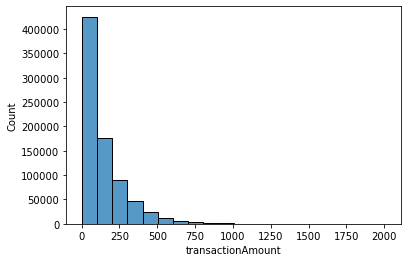

In [7]:
sns.histplot(data.transactionAmount, bins = 20)

## Summary
The transaction amount is highly left skewed. The higher the transaction amount, the less volume of customers. There are possibly outliers for this variable that could indicate suspicous fraud cases. We could investigate these outliers specifically to dig deeper. 

# 3. Data Wrangling

In [8]:
data = data.drop_duplicates()

In [9]:
data.transactionType.unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', ''], dtype=object)

In [10]:
# identify reverse transactions
reverse = data[data.transactionType == 'REVERSAL']
reverse

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,merchantState,cardPresent,recurringAuthInd,expirationDateKeyInMatch,isFraud
39,574788567,574788567,2500.0,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,09,01,auto,10/2021,2015-10-13,2015-10-13,206,206,8522,REVERSAL,299.02,,True,,False,False
73,574788567,574788567,2500.0,2432.72,2016-10-07T10:23:57,3.87,Eazy Repair,US,US,05,01,auto,10/2022,2015-10-13,2015-10-13,579,579,4219,REVERSAL,67.28,,True,,False,False
101,924729945,924729945,50000.0,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,05,01,online_retail,11/2024,2014-07-25,2014-07-25,205,265,9459,REVERSAL,168.57,,False,,False,False
133,984504651,984504651,50000.0,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,05,01,health,08/2028,2015-07-27,2015-07-27,640,640,8332,REVERSAL,3632.59,,False,,False,False
156,984504651,984504651,50000.0,41909.30,2016-01-25T20:39:15,81.73,AMC #724446,US,US,09,01,entertainment,12/2031,2015-07-27,2015-07-27,640,640,8332,REVERSAL,8090.70,,True,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786106,899818521,899818521,2500.0,968.33,2016-09-29T02:04:32,10.05,cheapfast.com,US,US,02,99,online_retail,02/2031,2013-06-15,2013-06-15,421,421,3424,REVERSAL,1531.67,,False,,False,False
786120,638498773,638498773,10000.0,9798.21,2016-01-01T19:48:03,201.79,KFC #928167,US,US,05,01,fastfood,11/2032,2014-11-17,2014-11-17,175,175,321,REVERSAL,201.79,,True,,False,False
786219,638498773,638498773,10000.0,5331.33,2016-11-03T04:23:26,86.14,Dunkin' Donuts #396342,US,US,05,01,fastfood,03/2025,2014-11-17,2014-11-17,387,387,4635,REVERSAL,4668.67,,True,,False,False
786225,638498773,638498773,10000.0,4393.10,2016-11-06T22:54:25,49.39,Shake Shack #118502,US,US,05,01,fastfood,06/2029,2014-11-17,2014-11-17,387,387,4635,REVERSAL,5606.90,,True,,False,False


In [11]:
# estimate total number of reversed transactions
reverse.groupby('transactionType')['transactionAmount'].count()

transactionType
REVERSAL    20303
Name: transactionAmount, dtype: int64

In [12]:
# estimate total dollar amount of reversed transactions
reverse.groupby('transactionType')['transactionAmount'].sum()

transactionType
REVERSAL    2821792.5
Name: transactionAmount, dtype: float64

In [13]:
# identify multi-swipe transactions
# define multi-swipe as swiping the same card with the same merchant multiple times within an hour
data['dateofTransaction'] = pd.to_datetime(data['transactionDateTime']).dt.date
data['hourofTransaction'] = pd.to_datetime(data['transactionDateTime']).dt.hour
multi = data[data['transactionType'] == 'PURCHASE'].groupby(['accountNumber', 'merchantName', 'dateofTransaction', 'hourofTransaction'],
                        as_index=False)['transactionType', 'transactionAmount'].agg({'transactionType':'count', 'transactionAmount': 'sum'})

# show duplicated PURCHASE transactions excluding the original transaction
multi.rename(columns = {'transactionType':'countofMultiSwipe'}, inplace = True)
multi = multi[multi['countofMultiSwipe']>1]
multi

,accountNumber,merchantName,dateofTransaction,hourofTransaction,countofMultiSwipe,transactionAmount
43,100088067,Fresh Flowers,2016-10-16,18,2,822.70
249,100737756,34th BBQ #166379,2016-07-10,14,2,86.50
315,100737756,Franks Deli,2016-01-18,1,3,2080.50
369,100737756,South Steakhouse #73819,2016-07-02,12,2,422.44
438,101132326,Regal Cinemas #05791,2016-08-24,2,2,377.72
...,...,...,...,...,...,...
730005,999086814,sears.com,2016-01-23,9,2,357.14
730025,999086814,staples.com,2016-08-04,0,2,345.00
730133,999257059,Wall Street News,2016-01-14,16,2,95.16
730146,999257059,Wall Street Times,2016-02-25,12,2,176.49


In [14]:
# estimate total number of reversed transactions
multi.countofMultiSwipe.sum()

27950

In [15]:
# estimate total dollar amount of reversed transactions
multi.transactionAmount.sum()

4179955.83

## Summary
There are 20303 reversed transactions and the total amount of reversed transactions is 2821792.5. 
There are 27950 multi-swipe transactions and the total amount of multi-swipe transactions is 4179955.83

# 4. Model

## Pearson Correlation for Numerical Variables

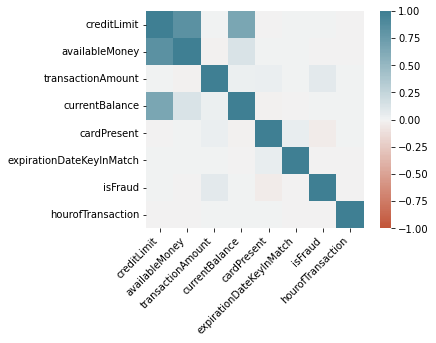

In [16]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Chi-square Testing for Categorical Variables

In [17]:
categorical.remove('isFraud')
# return significant categorical features
def Chi(dataset, y, cols = categorical):
    useful = []
    sig = []
    for col in cols:
        contingency_table = pd.crosstab(
            dataset[col],
            y,
            margins = True
                        )
        print(col,':')
        print(contingency_table, end = '                                              ')
        if contingency_table.iloc[1][1] > contingency_table.iloc[1][0]:
            print('Possibly Useful\n')
            useful.append(col)
        else:
            print('\n')

        a = []        
        j = len(contingency_table.iloc[0,:]) - 1     # of table column 
        for i in range(len(contingency_table.iloc[:,0]) - 1):
            f_obs = np.array([contingency_table.iloc[i][0:j].values])
            a.append(f_obs)

        print('Chi-square, p-value, and degree of freedom:')
        print(':         ', stats.chi2_contingency(a)[0:3], end = '                                     ')
        if stats.chi2_contingency(a)[1] <= 0.05:
            print('Significant')
            print('\n')
            sig.append(col)
        else:
#             dataset.drop(col, axis = 1, inplace = True)
            print('\n\n')
    print('Possibly useful features for filters\n' + str(useful))
    print('Significant variables:\n' + str(sig) + '\n\n---------------------------------------------')
    return sig


sig_cat_var = Chi(data, data.isFraud)

accountNumber :
isFraud         False   True     All
accountNumber                       
100088067          74      1      75
100108752          18      0      18
100328049         103      0     103
100663626          31      0      31
100737756         177      1     178
...               ...    ...     ...
999257059         158      2     160
999258704          87      1      88
999283629         141      0     141
999389635           9      0       9
All            773946  12417  786363

[5001 rows x 3 columns]                                              

Chi-square, p-value, and degree of freedom:
:          (22763.714027356244, 0.0, 4999)                                     Significant


customerId :
isFraud      False   True     All
customerId                       
100088067       74      1      75
100108752       18      0      18
100328049      103      0     103
100663626       31      0      31
100737756      177      1     178
...            ...    ...     ...
999257059

:          (9282.064668778237, 0.0, 2183)                                     Significant


cardCVV :
isFraud   False   True     All
cardCVV                       
100         189      3     192
101         995      5    1000
102         133      3     136
103         221      3     224
104        1289     14    1303
...         ...    ...     ...
995         952      9     961
996        2265     29    2294
997         312      2     314
998         840     10     850
All      773946  12417  786363

[900 rows x 3 columns]                                              

Chi-square, p-value, and degree of freedom:
:          (9069.580978561344, 0.0, 898)                                     Significant


enteredCVV :
isFraud      False   True     All
enteredCVV                       
000              7      1       8
001              1      0       1
003              6      0       6
004              1      0       1
005              2      0       2
...            ...    ...     ...
995 

## Upsampling due to Imbalanced Data

In [18]:
nonfraud = data[data['isFraud'] == False]
fraud  = data[data['isFraud'] == True]
print(nonfraud.shape)
print(fraud.shape)

(773946, 27)
(12417, 27)


In [19]:
from sklearn.utils import resample
fraud_upsample = resample(fraud,
             replace=True,
             n_samples=len(nonfraud),
             random_state=42)

print(fraud_upsample.shape)

(773946, 27)


<AxesSubplot:ylabel='Type'>

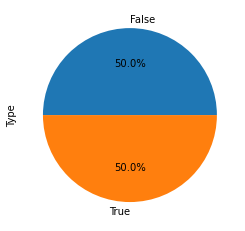

In [20]:
data = pd.concat([nonfraud, fraud_upsample])

data.groupby('isFraud').size().plot(kind='pie',
                                       y = "True",
                                       label = "Type",
                                       autopct='%1.1f%%')

## Split Training and Testing Sets

In [21]:
# separate data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(data, data.isFraud, test_size = 0.3, random_state = 200)
X_train.shape, X_test.shape

((1083524, 27), (464368, 27))

## Categorical Rare Imputation
- We need to handle high cardinality of categorical variables by grouping rare labels into a category called "rare" and replacing those relatively non-rare labels with the mode (most frequent label) of variables

- For encoding categorical variables, the variables with more than 2 labels are encoded with target encoding. Those variables with two labels(posConditionCode, cardPresent, expirationDateKeyInMatch, isFraud) are transferred to binary numerical variables.

In [22]:
# check weights of labels in categorical variables and find unfrequent labels in categorical variables
def check_cat_wt(cols, dataset):
    for var in cols:
        print(var, dataset[var].value_counts()/np.float(len(dataset)), dataset.groupby([var])['isFraud'].mean())
        print()

check_cat_wt(categorical, data)

accountNumber 380680241    5.208051e-02
246251253    1.748830e-02
782081187    1.374644e-02
700725639    1.271536e-02
882815134    1.241430e-02
                 ...     
897071504    6.460399e-07
897227769    6.460399e-07
266636812    6.460399e-07
533349434    6.460399e-07
220057198    6.460399e-07
Name: accountNumber, Length: 5000, dtype: float64 accountNumber
100088067    0.451852
100108752    0.000000
100328049    0.000000
100663626    0.000000
100737756    0.277551
               ...   
999086814    0.325301
999257059    0.466216
999258704    0.459627
999283629    0.000000
999389635    0.000000
Name: isFraud, Length: 5000, dtype: float64

customerId 380680241    5.208051e-02
246251253    1.748830e-02
782081187    1.374644e-02
700725639    1.271536e-02
882815134    1.241430e-02
                 ...     
897071504    6.460399e-07
897227769    6.460399e-07
266636812    6.460399e-07
533349434    6.460399e-07
220057198    6.460399e-07
Name: customerId, Length: 5000, dtype: float64 custo

cardLast4Digits 593     5.214253e-02
6002    1.748830e-02
9522    1.271536e-02
2178    1.214103e-02
7629    1.160223e-02
            ...     
7127    6.460399e-07
501     6.460399e-07
211     6.460399e-07
1877    6.460399e-07
1803    6.460399e-07
Name: cardLast4Digits, Length: 5246, dtype: float64 cardLast4Digits
0       0.000000
0000    0.387794
1       0.000000
100     0.617391
1000    0.524490
          ...   
9993    0.000000
9994    0.000000
9996    0.542017
9997    0.000000
9998    0.000000
Name: isFraud, Length: 5246, dtype: float64

transactionType PURCHASE                0.954862
REVERSAL                0.026516
ADDRESS_VERIFICATION    0.017606
                        0.001016
Name: transactionType, dtype: float64 transactionType
                        0.564885
ADDRESS_VERIFICATION    0.264164
PURCHASE                0.503903
REVERSAL                0.513546
Name: isFraud, dtype: float64

currentBalance 0.00       3.939939e-02
2001.67    1.143491e-04
6875.36    1.053045e-04
7

In [23]:
def rare_imputation(variable, rare_imputer, which = 'rare'):    
    
    # find frequent labels
    temp = X_train.groupby([variable])[variable].count()/np.float(len(X_train))
    frequent_cat = [x for x in temp.loc[temp > 0.01].index.values]
    
    # create new variables, with Rare labels imputed
    if which == 'frequent':
        # find the most frequent category
        mode_label = X_train.groupby(variable)[variable].count().sort_values().tail(1).index.values[0]
        X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], mode_label)
        X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], mode_label)  
        rare_imputer[variable] = [frequent_cat, mode_label]
    else:
        X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'rare')
        X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'rare')
        rare_imputer[variable] = [frequent_cat, 'rare']
    return rare_imputer

In [24]:
rare_imputer = {}
for col in categorical:
    if len(X_train[col].unique()) >= 3 and len(X_train[col].unique()) <= 5:
        rare_imputation(col, rare_imputer, 'frequent')
        rare_imputer = rare_imputation(col, rare_imputer, 'frequent')
    else:
        rare_imputation(col, rare_imputer, 'rare')
        rare_imputer = rare_imputation(col, rare_imputer, 'rare')
        # find scarse label
        temp = X_train.groupby([col])[col].count()/np.float(len(X_train))
        scarse_cat = [x for x in temp.loc[temp < 0.2].index.values]
        if col!= 'isFraud' and len(X_train[col].unique()) <= 2 and scarse_cat in X_train[col].unique():
            X_train.drop(col, axis = 1, inplace = True)
            X_test.drop(col, axis = 1, inplace = True)
categorical, numerical = find_cat_and_num(X_train)
categorical, numerical = find_cat_and_num(X_test)

delete transactionDateTime from the dataset because it is a constant
delete acqCountry from the dataset because it is a constant
delete currentExpDate from the dataset because it is a constant
delete merchantState from the dataset because it is a constant
delete recurringAuthInd from the dataset because it is a constant
delete transactionDateTime from the dataset because it is a constant
delete acqCountry from the dataset because it is a constant
delete currentExpDate from the dataset because it is a constant
delete merchantState from the dataset because it is a constant
delete recurringAuthInd from the dataset because it is a constant


In [25]:
check_cat_wt(categorical, X_train)

accountNumber rare         0.856142
380680241    0.052029
246251253    0.017534
782081187    0.013687
700725639    0.012728
882815134    0.012422
419709514    0.012160
472288969    0.011786
208319653    0.011512
Name: accountNumber, dtype: float64 accountNumber
208319653    0.718775
246251253    0.636699
380680241    0.601792
419709514    0.697025
472288969    0.916758
700725639    0.844754
782081187    0.898584
882815134    0.318648
rare         0.470648
Name: isFraud, dtype: float64

customerId rare         0.856142
380680241    0.052029
246251253    0.017534
782081187    0.013687
700725639    0.012728
882815134    0.012422
419709514    0.012160
472288969    0.011786
208319653    0.011512
Name: customerId, dtype: float64 customerId
208319653    0.718775
246251253    0.636699
380680241    0.601792
419709514    0.697025
472288969    0.916758
700725639    0.844754
782081187    0.898584
882815134    0.318648
rare         0.470648
Name: isFraud, dtype: float64

transactionAmount 0.00     

In [26]:
def target_encoding(var, target):
    # make label to risk dictionary
    ordered_labels = X_train.groupby([var])[target].mean().to_dict()
    # encode variables
    X_train[var] = X_train[var].map(ordered_labels)
    X_test[var] = X_test[var].map(ordered_labels)

In [27]:
for var in categorical:
    if len(X_train[var].unique()) > 2:
        target_encoding(var, 'isFraud')
    elif len(X_train[var].unique()) == 2:
        d = {'False': 1, 'True': 0, '01': 1, '08': 0}
        X_train.replace(d, inplace = True)
        X_test.replace(d, inplace = True)

In [28]:
X_train.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,accountOpenDate,cardCVV,enteredCVV,cardLast4Digits,transactionType,cardPresent,isFraud,dateofTransaction,hourofTransaction
512183,0.470648,0.470648,15000.0,8153.86,0.906250,0.621977,US,0.605015,0.508248,0.609913,0.470545,0.482431,0.483016,0.481001,0.503918,1,True,0.602694,21
86445,0.470648,0.470648,5000.0,496.19,0.807018,0.373061,US,0.605015,0.508248,0.376015,0.470545,0.482431,0.483016,0.481001,0.503918,0,True,0.514789,9
240223,0.601792,0.601792,5000.0,2256.48,0.969697,0.815741,US,0.605015,0.508248,0.607718,0.598503,0.598368,0.594549,0.601099,0.503918,1,True,0.581011,6
301762,0.470648,0.470648,250.0,201.58,0.695652,0.373061,US,0.328534,0.508248,0.455446,0.470545,0.482431,0.483016,0.481001,0.503918,0,True,0.524614,11
112550,0.470648,0.470648,10000.0,9697.38,0.936508,0.600226,US,0.605015,0.508248,0.609913,0.470545,0.482431,0.483016,0.481001,0.503918,1,True,0.503327,21


In [29]:
X_test.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,accountOpenDate,cardCVV,enteredCVV,cardLast4Digits,transactionType,cardPresent,isFraud,dateofTransaction,hourofTransaction
486997,0.470648,0.470648,2500.0,2101.70,0.000000,0.657685,US,0.524951,0.448198,0.614986,0.470545,0.482431,0.483016,0.481001,0.503918,1,False,0.496205,0
482558,0.470648,0.470648,7500.0,3006.46,0.727273,0.627708,US,0.524951,0.508248,0.609913,0.470545,0.482431,0.483016,0.481001,0.503918,1,True,0.563929,6
504159,0.470648,0.470648,20000.0,9809.38,0.652174,0.657685,US,0.524951,0.508248,0.614986,0.470545,0.482431,0.483016,0.481001,0.514090,1,True,0.489744,9
178015,0.470648,0.470648,5000.0,1291.01,0.256908,0.579165,US,0.328534,0.508248,0.609913,0.470545,0.482431,0.483016,0.481001,0.265028,1,False,0.539928,12
510177,0.470648,0.470648,15000.0,14257.18,0.660377,0.565961,US,0.605015,0.508248,0.609913,0.470545,0.482431,0.483016,0.481001,0.503918,1,True,0.506252,23


In [30]:
check_missing(X_train)

accountNumber                        0.0
customerId                        0.0
creditLimit                        0.0
availableMoney                        0.0
transactionAmount                        0.0
merchantName                        0.0
merchantCountryCode                        0.0
posEntryMode                        0.0
posConditionCode                        0.0
merchantCategoryCode                        0.0
accountOpenDate                        0.0
cardCVV                        0.0
enteredCVV                        0.0
cardLast4Digits                        0.0
transactionType                        0.0
cardPresent                        0.0
isFraud                        0.0
dateofTransaction                        0.0
hourofTransaction                        0.0


In [31]:
check_missing(X_test)

accountNumber                        0.0
customerId                        0.0
creditLimit                        0.0
availableMoney                        0.0
transactionAmount                        0.013101677979533474
merchantName                        0.0
merchantCountryCode                        0.0
posEntryMode                        0.0
posConditionCode                        0.0
merchantCategoryCode                        0.0
accountOpenDate                        0.0
cardCVV                        0.0
enteredCVV                        0.0
cardLast4Digits                        0.0
transactionType                        0.0
cardPresent                        0.0
isFraud                        0.0
dateofTransaction                        0.0
hourofTransaction                        0.0


In [32]:
X_test['transactionAmount'].fillna(X_test['transactionAmount'].median(), inplace = True) 

## Algorithm Fitting and Hyperparameter Tuning

In [33]:
training_vars = [i for i in X_train.columns if i not in ['accountNumber', 'customerId', 'merchantCountryCode', 'dateofTransaction',\
                                                        'hourofTransaction', 'isFraud']]

### xgBoost

In [42]:
xgb_model = xgb.XGBClassifier()

eval_set = [(X_test[training_vars], y_test)]
xgb_model.fit(X_train[training_vars], y_train, eval_metric="auc", eval_set = eval_set, verbose=False)

pred_prob_train = xgb_model.predict_proba(X_train[training_vars])
print('xgb train roc-auc: {}'.format(roc_auc_score(y_train, pred_prob_train[:,1])))
pred_prob = xgb_model.predict_proba(X_test[training_vars])
print('xgb test roc-auc: {}'.format(roc_auc_score(y_test, pred_prob[:,1])) ) #roc_auc_score(y_test, pred_prob[:,1]
joblib.dump(xgb_model, 'xgb_model.pkl')

y_pred_train = xgb_model.predict(X_train[training_vars])
y_pred = xgb_model.predict(X_test[training_vars])
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
precision = cm[1,1]/(cm[1,1] + cm[0,1])
recall = cm[1,1]/(cm[1,1] + cm[1,0])
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('F-1 Score: {}'.format(2/(1/precision + 1/recall)))

xgb train roc-auc: 0.9601489822134979
xgb test roc-auc: 0.9530732790351047
[[186104  46059]
 [  8625 223580]]
Precision: 0.8291827220839715
Recall: 0.9628560969832691
Accuracy: 0.8822399476277435
F-1 Score: 0.8910338670981419


In [35]:
# xgb_model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1)
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

# # gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = params, scoring='roc_auc',iid=False,cv=5)



# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train[training_vars],y_train), verbose=3, random_state=1001 )
# random_search.fit(X_train[training_vars], y_train.ravel())
# print(random_search.best_params_, random_search.best_score_)

In [36]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv('xgb-random-grid-search-results-01.csv', index=False)
# # y_test = random_search.predict_proba(X_test[training_vars])

# pred_prob = random_search.predict_proba(X_train[training_vars])
# print('xgb train roc-auc: {}'.format(roc_auc_score(y_train, pred_prob[:,1])))
# pred_prob = random_search.predict_proba(X_test[training_vars])
# print('xgb test roc-auc: {}'.format(roc_auc_score(y_test, pred_prob[:,1])))
# joblib.dump(xgb_model, 'xgb_model_pre.pkl')

# # y_pred = xgb_model.predict(X_train[training_vars])
# y_pred = random_search.predict(X_test[training_vars])
# # Confusion Matrix
# from sklearn.metrics import confusion_matrix, accuracy_score
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# print('Precision: {}'.format(cm[1,1]/(cm[1,1] + cm[0,1])))
# print('Recall: {}'.format(cm[1,1]/(cm[1,1] + cm[1,0])))
# print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
# # print('F-1 Score: {}'.format(2/(1/precision + 1/recall)))

### Random Forest

In [37]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train[training_vars], y_train)

pred_prob_train = rf_model.predict_proba(X_train[training_vars])
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, pred_prob_train[:,1])))
pred_prob = rf_model.predict_proba(X_test[training_vars])
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, pred_prob[:,1])))

joblib.dump(rf_model, 'rf_model.pkl')

y_pred = rf_model.predict(X_test[training_vars])

cm = confusion_matrix(y_test, y_pred)
print(cm)
precision = cm[1,1]/(cm[1,1] + cm[0,1])
recall = cm[1,1]/(cm[1,1] + cm[1,0])
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('F-1 Score: {}'.format(2/(1/precision + 1/recall)))

RF train roc-auc: 0.9999999985605068
RF test roc-auc: 0.9999567879424893
[[229820   2343]
 [     0 232205]]
Precision: 0.9900105735286594
Recall: 1.0
Accuracy: 0.9949544326913138
F-1 Score: 0.9949802143746266


## Feature Importance Ranking

<AxesSubplot:>

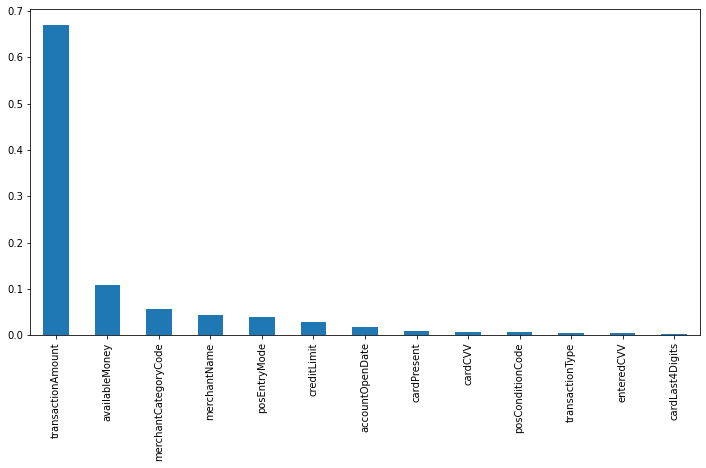

In [38]:
importance = pd.Series(rf_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
# training_vars_rf = [i for i in importance.index if importance[i] >= 0.01]
importance.plot.bar(figsize=(12,6))

<AxesSubplot:>

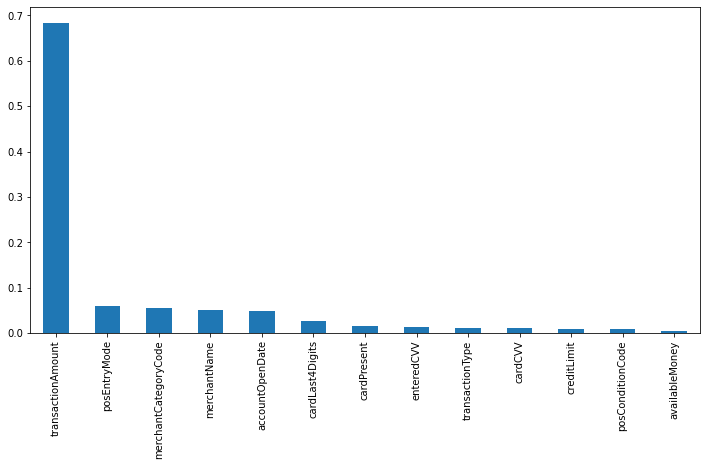

In [39]:
importance = pd.Series(xgb_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
# training_vars_xgb = [i for i in importance.index if importance[i] >= 0.01]
importance.plot.bar(figsize=(12,6))

## More Detailed Results of xgBoost Model

No Skill: ROC AUC=0.500
xgBoost: ROC AUC=0.953


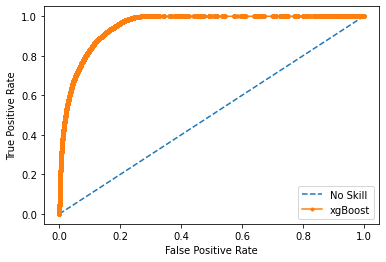

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# # fit a model

xgb_model.fit(X_train[training_vars], y_train)

# predict probabilities
lr_probs = xgb_model.predict_proba(X_test[training_vars])
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('xgBoost: ROC AUC=%.3f' % (lr_auc))   
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='xgBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [43]:
pred_df = pd.DataFrame(
    {"predicted":y_pred,
     "prob_0":pred_prob[:, 0],
     "prob_1":pred_prob[:, 1]
    }
                        )
# y_test = y_test.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
# X_train = X_train.reset_index(drop = True)
predict = pd.concat([X_test, pred_df], axis = 1)
predict.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,accountOpenDate,cardCVV,enteredCVV,cardLast4Digits,transactionType,cardPresent,isFraud,dateofTransaction,hourofTransaction,predicted,prob_0,prob_1
0,0.470648,0.470648,2500.0,2101.70,0.000000,0.657685,US,0.524951,0.448198,0.614986,0.470545,0.482431,0.483016,0.481001,0.503918,1,False,0.496205,0,False,0.999531,0.000469
1,0.470648,0.470648,7500.0,3006.46,0.727273,0.627708,US,0.524951,0.508248,0.609913,0.470545,0.482431,0.483016,0.481001,0.503918,1,True,0.563929,6,True,0.187127,0.812873
2,0.470648,0.470648,20000.0,9809.38,0.652174,0.657685,US,0.524951,0.508248,0.614986,0.470545,0.482431,0.483016,0.481001,0.514090,1,True,0.489744,9,True,0.234912,0.765088
3,0.470648,0.470648,5000.0,1291.01,0.256908,0.579165,US,0.328534,0.508248,0.609913,0.470545,0.482431,0.483016,0.481001,0.265028,1,False,0.539928,12,False,0.789906,0.210094
4,0.470648,0.470648,15000.0,14257.18,0.660377,0.565961,US,0.605015,0.508248,0.609913,0.470545,0.482431,0.483016,0.481001,0.503918,1,True,0.506252,23,True,0.203574,0.796426


## Summary

- xgBoost and Random Forest algorithms are ensemble learning algorithms that combine week learners(single decision tree) into strong learners. They both can help avoid overfitting especially there is regularization embedded with xgBoost. Random Forest(Bagging) can help reduce testing variance. xgBoost(Boosting) can help reduce both the testing bias and variance. They both can handle imbalanced data(in this case isFraud is quite imbalanced) very well. Also, tree algorithms have several advantages over linear algorithms such as logistic regression:
    1. robust to outliers, therefore it saves time of treating outliers

    2. does not calculate euclidean distance, therefore there is no need of feature scaling

    3. does not need multicollinearity check

    4. still has some level of interpretability regarding feature importance ranking based on Gini index


- Both algorithms yield pretty good model results regarding ROC-AUC and accuracy. The probability threshold should be adjusted to change precision and recall and optimize the result based on our business goal - reduce fraud rate.

- The independence test on categorical variables(chi-square test) returned the significant categorical variables that isFraud is dependent on. However, since the tree algorithms were chosen, the useful features are the ones rank high on the feature importance ranking plot such as: transactionAmount, posEntryMode, merchantCategoryCode, merchantName.

- If more time is allowed, feature engineering based on business domain knowledge to create more meaningful feature or transform some current features could be done. Hyperparameter tuning (codes provided but commented above) on these two algorithms could also be done to further improve the prediction power. 